# 3D Metrology


* Train Dataset (학습용 데이터셋, 학습 가능) - 총 60664개
SEM [폴더] : 실제 SEM 영상을 Hole 단위로 분할한 영상 (8bit Gray 영상)
average_depth.csv : 전체 SEM 영상과 대응되는 평균 Depth


* Simulation Dataset (학습용 데이터셋, 학습 가능) - 총 259956개
  * SEM [폴더] : Simulator을 통해 생성한 Hole 단위 SEM 영상 (실제 SEM 영상과 유사하나, 대응 관계는 없음)
  * Depth [폴더] : Simulator을 통해 얻은 SEM 영상과 Pixel별로 대응되는 Depth Map
Depth 이미지 1개당 2개의 Simulator Hole 단위 SEM 영상이 Pair하게 매칭됩니다. (Name_itr0, Name_itr1)


* Test Dataset (평가를 위한 테스트 데이터셋, 학습 불가능) - 총 25998개
SEM [폴더] : 실제 SEM 영상을 Hole 단위로 분할한 영상 (8bit Gray 영상)


* sample_submission.zip (제출 양식) - 총 25998개
실제 Hole 단위 SEM 영상으로부터 추론한 Depth Map (.png, int)

## Import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')
 
from google.colab.patches import cv2_imshow

from torchvision import transforms # 데이터 증강을 위한 transform

import PIL # 이미지

from copy import deepcopy # 값 복사하기위한 라이브러리

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/공유 드라이브/삼성데이콘/open.zip"    # 로컬

## Hyperparameter Setting

In [ ]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':64,
    'SEED':41,
    'ALPHA':1e-2
}

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## K-Fold 방식의 데이터 분할

In [ ]:
## sem 비율 적당히 해서 쪼개기

# case 1 
sim_sem_c1_80_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/80/*.png'))
sim_sem_c1_81_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/81/*.png'))
sim_sem_c1_82_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/82/*.png'))
sim_sem_c1_83_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/83/*.png'))
sim_sem_c1_84_paths = sorted(glob.glob('./simulation_data/SEM/Case_1/84/*.png'))

# case 2
sim_sem_c2_80_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/80/*.png'))
sim_sem_c2_81_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/81/*.png'))
sim_sem_c2_82_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/82/*.png'))
sim_sem_c2_83_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/83/*.png'))
sim_sem_c2_84_paths = sorted(glob.glob('./simulation_data/SEM/Case_2/84/*.png'))

# case 3
sim_sem_c3_80_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/80/*.png'))
sim_sem_c3_81_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/81/*.png'))
sim_sem_c3_82_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/82/*.png'))
sim_sem_c3_83_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/83/*.png'))
sim_sem_c3_84_paths = sorted(glob.glob('./simulation_data/SEM/Case_3/84/*.png'))

# case 4
sim_sem_c4_80_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/80/*.png'))
sim_sem_c4_81_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/81/*.png'))
sim_sem_c4_82_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/82/*.png'))
sim_sem_c4_83_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/83/*.png'))
sim_sem_c4_84_paths = sorted(glob.glob('./simulation_data/SEM/Case_4/84/*.png'))

## depth 비율 적당히 해서 쪼개기

# case 1
sim_depth_c1_80_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/80/*.png') + glob.glob('./simulation_data/Depth/Case_1/80/*.png'))
sim_depth_c1_81_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/81/*.png') + glob.glob('./simulation_data/Depth/Case_1/81/*.png'))
sim_depth_c1_82_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/82/*.png') + glob.glob('./simulation_data/Depth/Case_1/82/*.png'))
sim_depth_c1_83_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/83/*.png') + glob.glob('./simulation_data/Depth/Case_1/83/*.png'))
sim_depth_c1_84_paths = sorted(glob.glob('./simulation_data/Depth/Case_1/84/*.png') + glob.glob('./simulation_data/Depth/Case_1/84/*.png'))

# case 2
sim_depth_c2_80_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/80/*.png') + glob.glob('./simulation_data/Depth/Case_2/80/*.png'))
sim_depth_c2_81_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/81/*.png') + glob.glob('./simulation_data/Depth/Case_2/81/*.png'))
sim_depth_c2_82_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/82/*.png') + glob.glob('./simulation_data/Depth/Case_2/82/*.png'))
sim_depth_c2_83_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/83/*.png') + glob.glob('./simulation_data/Depth/Case_2/83/*.png'))
sim_depth_c2_84_paths = sorted(glob.glob('./simulation_data/Depth/Case_2/84/*.png') + glob.glob('./simulation_data/Depth/Case_2/84/*.png'))

# case 3
sim_depth_c3_80_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/80/*.png') + glob.glob('./simulation_data/Depth/Case_3/80/*.png'))
sim_depth_c3_81_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/81/*.png') + glob.glob('./simulation_data/Depth/Case_3/81/*.png'))
sim_depth_c3_82_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/82/*.png') + glob.glob('./simulation_data/Depth/Case_3/82/*.png'))
sim_depth_c3_83_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/83/*.png') + glob.glob('./simulation_data/Depth/Case_3/83/*.png'))
sim_depth_c3_84_paths = sorted(glob.glob('./simulation_data/Depth/Case_3/84/*.png') + glob.glob('./simulation_data/Depth/Case_3/84/*.png'))

# case 4
sim_depth_c4_80_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/80/*.png') + glob.glob('./simulation_data/Depth/Case_4/80/*.png'))
sim_depth_c4_81_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/81/*.png') + glob.glob('./simulation_data/Depth/Case_4/81/*.png'))
sim_depth_c4_82_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/82/*.png') + glob.glob('./simulation_data/Depth/Case_4/82/*.png'))
sim_depth_c4_83_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/83/*.png') + glob.glob('./simulation_data/Depth/Case_4/83/*.png'))
sim_depth_c4_84_paths = sorted(glob.glob('./simulation_data/Depth/Case_4/84/*.png') + glob.glob('./simulation_data/Depth/Case_4/84/*.png'))

In [ ]:
# 각 case의 서브폴더(80,81,82,83) 안의 길이 확인
 
len_80 = len(sim_sem_c1_80_paths)
len_81 = len(sim_sem_c1_81_paths)
len_82 = len(sim_sem_c1_82_paths)
len_83 = len(sim_sem_c1_83_paths)
len_84 = len(sim_sem_c2_84_paths)

In [ ]:
# 이용하고 싶은 data 비율 정하기
ratio = 0.8

In [ ]:
# validation 자르고 싶은 비율 정하기
v_ratio = 0.2

In [ ]:
# train sem paths 정하기

vc1_80 = sim_sem_c1_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
vc1_81 = sim_sem_c1_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
vc1_82 = sim_sem_c1_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
vc1_83 = sim_sem_c1_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
vc1_84 = sim_sem_c1_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
vc1 = vc1_80 + vc1_81 + vc1_82 + vc1_83 + vc1_84

vc2_80 = sim_sem_c2_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
vc2_81 = sim_sem_c2_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
vc2_82 = sim_sem_c2_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
vc2_83 = sim_sem_c2_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
vc2_84 = sim_sem_c2_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
vc2 = vc2_80 + vc2_81 + vc2_82 + vc2_83 + vc2_84

vc3_80 = sim_sem_c3_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
vc3_81 = sim_sem_c3_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
vc3_82 = sim_sem_c3_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
vc3_83 = sim_sem_c3_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
vc3_84 = sim_sem_c3_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
vc3 = vc3_80 + vc3_81 + vc3_82 + vc3_83 + vc3_84

vc4_80 = sim_sem_c4_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
vc4_81 = sim_sem_c4_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
vc4_82 = sim_sem_c4_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
vc4_83 = sim_sem_c4_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
vc4_84 = sim_sem_c4_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
vc4 = vc4_80 + vc4_81 + vc4_82 + vc4_83 + vc4_84

tsvc = vc1 + vc2 + vc3 + vc4

In [ ]:
# train depth paths 정하기

dvc1_80 = sim_depth_c1_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
dvc1_81 = sim_depth_c1_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
dvc1_82 = sim_depth_c1_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
dvc1_83 = sim_depth_c1_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
dvc1_84 = sim_depth_c1_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
dvc1 = dvc1_80 + dvc1_81 + dvc1_82 + dvc1_83 + dvc1_84

dvc2_80 = sim_depth_c2_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
dvc2_81 = sim_depth_c2_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
dvc2_82 = sim_depth_c2_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
dvc2_83 = sim_depth_c2_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
dvc2_84 = sim_depth_c2_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
dvc2 = dvc2_80 + dvc2_81 + dvc2_82 + dvc2_83 + dvc2_84

dvc3_80 = sim_depth_c3_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
dvc3_81 = sim_depth_c3_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
dvc3_82 = sim_depth_c3_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
dvc3_83 = sim_depth_c3_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
dvc3_84 = sim_depth_c3_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
dvc3 = dvc3_80 + dvc3_81 + dvc3_82 + dvc3_83 + dvc3_84

dvc4_80 = sim_depth_c4_80_paths[int(len_80*v_ratio):int(len_80*ratio)]
dvc4_81 = sim_depth_c4_81_paths[int(len_81*v_ratio):int(len_81*ratio)]
dvc4_82 = sim_depth_c4_82_paths[int(len_82*v_ratio):int(len_82*ratio)]
dvc4_83 = sim_depth_c4_83_paths[int(len_83*v_ratio):int(len_83*ratio)]
dvc4_84 = sim_depth_c4_84_paths[int(len_84*v_ratio):int(len_84*ratio)]
dvc4 = dvc4_80 + dvc4_81 + dvc4_82 + dvc4_83 + dvc4_84

tdvc = dvc1 + dvc2 + dvc3 + dvc4

In [ ]:
# valid sem paths 정하기

vc1_80 = sim_sem_c1_80_paths[:int(len_80*v_ratio)]
vc1_81 = sim_sem_c1_81_paths[:int(len_81*v_ratio)]
vc1_82 = sim_sem_c1_82_paths[:int(len_82*v_ratio)]
vc1_83 = sim_sem_c1_83_paths[:int(len_83*v_ratio)]
vc1_84 = sim_sem_c1_84_paths[:int(len_84*v_ratio)]
vc1 = vc1_80 + vc1_81 + vc1_82 + vc1_83 + vc1_84

vc2_80 = sim_sem_c2_80_paths[:int(len_80*v_ratio)]
vc2_81 = sim_sem_c2_81_paths[:int(len_81*v_ratio)]
vc2_82 = sim_sem_c2_82_paths[:int(len_82*v_ratio)]
vc2_83 = sim_sem_c2_83_paths[:int(len_83*v_ratio)]
vc2_84 = sim_sem_c2_84_paths[:int(len_84*v_ratio)]
vc2 = vc2_80 + vc2_81 + vc2_82 + vc2_83 + vc2_84

vc3_80 = sim_sem_c3_80_paths[:int(len_80*v_ratio)]
vc3_81 = sim_sem_c3_81_paths[:int(len_81*v_ratio)]
vc3_82 = sim_sem_c3_82_paths[:int(len_82*v_ratio)]
vc3_83 = sim_sem_c3_83_paths[:int(len_83*v_ratio)]
vc3_84 = sim_sem_c3_84_paths[:int(len_84*v_ratio)]
vc3 = vc3_80 + vc3_81 + vc3_82 + vc3_83 + vc3_84

vc4_80 = sim_sem_c4_80_paths[:int(len_80*v_ratio)]
vc4_81 = sim_sem_c4_81_paths[:int(len_81*v_ratio)]
vc4_82 = sim_sem_c4_82_paths[:int(len_82*v_ratio)]
vc4_83 = sim_sem_c4_83_paths[:int(len_83*v_ratio)]
vc4_84 = sim_sem_c4_84_paths[:int(len_84*v_ratio)]
vc4 = vc4_80 + vc4_81 + vc4_82 + vc4_83 + vc4_84

vsvc = vc1 + vc2 + vc3 + vc4

In [ ]:
# valid depth 길이 정하기

dvc1_80 = sim_depth_c1_80_paths[:int(len_80*v_ratio)]
dvc1_81 = sim_depth_c1_81_paths[:int(len_81*v_ratio)]
dvc1_82 = sim_depth_c1_82_paths[:int(len_82*v_ratio)]
dvc1_83 = sim_depth_c1_83_paths[:int(len_83*v_ratio)]
dvc1_84 = sim_depth_c1_84_paths[:int(len_84*v_ratio)]
dvc1 = dvc1_80 + dvc1_81 + dvc1_82 + dvc1_83 + dvc1_84

dvc2_80 = sim_depth_c2_80_paths[:int(len_80*v_ratio)]
dvc2_81 = sim_depth_c2_81_paths[:int(len_81*v_ratio)]
dvc2_82 = sim_depth_c2_82_paths[:int(len_82*v_ratio)]
dvc2_83 = sim_depth_c2_83_paths[:int(len_83*v_ratio)]
dvc2_84 = sim_depth_c2_84_paths[:int(len_84*v_ratio)]
dvc2 = dvc2_80 + dvc2_81 + dvc2_82 + dvc2_83 + dvc2_84

dvc3_80 = sim_depth_c3_80_paths[:int(len_80*v_ratio)]
dvc3_81 = sim_depth_c3_81_paths[:int(len_81*v_ratio)]
dvc3_82 = sim_depth_c3_82_paths[:int(len_82*v_ratio)]
dvc3_83 = sim_depth_c3_83_paths[:int(len_83*v_ratio)]
dvc3_84 = sim_depth_c3_84_paths[:int(len_84*v_ratio)]
dvc3 = dvc3_80 + dvc3_81 + dvc3_82 + dvc3_83 + dvc3_84

dvc4_80 = sim_depth_c4_80_paths[:int(len_80*v_ratio)]
dvc4_81 = sim_depth_c4_81_paths[:int(len_81*v_ratio)]
dvc4_82 = sim_depth_c4_82_paths[:int(len_82*v_ratio)]
dvc4_83 = sim_depth_c4_83_paths[:int(len_83*v_ratio)]
dvc4_84 = sim_depth_c4_84_paths[:int(len_84*v_ratio)]
dvc4 = dvc4_80 + dvc4_81 + dvc4_82 + dvc4_83 + dvc4_84

vdvc = dvc1 + dvc2 + dvc3 + dvc4

In [ ]:
train_sem_paths = tsvc
train_depth_paths = tdvc

val_sem_paths = vsvc
val_depth_paths = vdvc

In [ ]:
len(train_sem_paths)

103988

## Data Augmentation으로 데이터 증강

In [ ]:
class TransformedDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list, label, transform = None):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        self.transform = transform
        self.label = label
        
    def __getitem__(self, index):
        sem_path = self.sem_path_list[index]
        sem_img = PIL.Image.open(sem_path).convert("L")
        if(self.transform):
            sem_img = self.transform(sem_img)
        sem_img = np.array(sem_img)
        sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
        sem_img = sem_img / 255.

        if self.depth_path_list is not None:
            depth_path = self.depth_path_list[index]
            depth_img = PIL.Image.open(depth_path).convert("L")
            if(self.transform):
                depth_img = self.transform(depth_img)
            depth_img = np.array(depth_img)
            depth_img = np.expand_dims(depth_img, axis=-1).transpose(2,0,1)
            depth_img = depth_img / 255.
            label = self.label

            return torch.Tensor(sem_img), torch.Tensor(depth_img), torch.Tensor(label)  
          

        else:
            img_name = sem_path.split('/')[-1]                                    # test의 경우는 depth_map이 없으니 무시하고 빠져나감
            label = self.label                                          # train으로 train_to_depth를 만들려고 할 때는 이 정보를 이용하기 위해 가져옴
            return torch.Tensor(sem_img), img_name, torch.Tensor(label)       # B,C,H,W
          
            
    def __len__(self):
        return len(self.sem_path_list)

In [ ]:
horizontalTransform = transforms.RandomHorizontalFlip(1.0)
verticalTransform = transforms.RandomVerticalFlip(1.0)
mixTransform = transforms.RandomRotation((180,180))

In [ ]:
t_origindataset = TransformedDataset(train_sem_paths, train_depth_paths, torch.Tensor([0,]),None)
t_horizontalTransformeddataset = TransformedDataset(train_sem_paths, train_depth_paths, torch.Tensor([0,]), transform = horizontalTransform)
t_verticalTransformeddataset = TransformedDataset(train_sem_paths, train_depth_paths, torch.Tensor([0,]), transform = verticalTransform)
t_mixdataset = TransformedDataset(train_sem_paths,train_depth_paths, torch.Tensor([0,]), transform = mixTransform)

train_dataset = t_origindataset + t_horizontalTransformeddataset + t_verticalTransformeddataset + t_mixdataset # train_dataset : 원본 + 좌우반전 + 상하반전

In [ ]:
v_origindataset = TransformedDataset(val_sem_paths, val_depth_paths, torch.Tensor([0,]),None)
v_horizontalTransformeddataset = TransformedDataset(val_sem_paths, val_depth_paths, torch.Tensor([0,]), transform = horizontalTransform)
v_verticalTransformeddataset = TransformedDataset(val_sem_paths, val_depth_paths, torch.Tensor([0,]), transform = verticalTransform)
v_mixdataset = TransformedDataset(val_sem_paths,val_depth_paths, torch.Tensor([0,]), transform = mixTransform)

valid_dataset = v_origindataset + v_horizontalTransformeddataset + v_verticalTransformeddataset + v_mixdataset # valid_dataset : 원본 + 좌우반전 + 상하반전

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = True, num_workers = 6)
valid_loader = DataLoader(valid_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = False, num_workers = 6) # 지표니까 크게 신경 안써도 됨.

## New Model Define

### New Model 구조 
기존의 BaseLine Model 의 출력 직전에 depth를 수치로 표현하도록 Linear로 연결

Encoder -> Decoder -> output1 (depth map)
                   
        -> output2 (depth 추정치)

In [ ]:
class NewModel(nn.Module):
    def __init__(self):
        super(NewModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,128,3, stride=2, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,3, stride=2, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,512,3,stride=2, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            )
        
        self.flatten = nn.Sequential(nn.Flatten(start_dim = 1),
                                     nn.Dropout(0.2))

        self.encoder_lin = nn.Sequential(
            nn.Linear(512*9*6,1024),
            nn.ReLU(),
            nn.Linear(1024, 512*9*6),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size = (512,9,6))
        
       
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512,256,3,stride=2,padding = 1,output_padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256,128,3, stride=2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,1,3, stride=2, padding = 1, output_padding = 1)
        )

        self.Regressor = nn.Sequential(                                         # depth 추정 regressor
            nn.Dropout(0.2),
            nn.Linear(512*9*6,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024,1),
        )

        
    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.encoder_lin(x) 
        r = self.Regressor(x)
        #print(x.shape)
        x = self.unflatten(x)
        #print(x.shape)
        x = self.decoder(x)                                                     # decoder 를 빠져나온 x는 추정된 depth map이 일렬로 쭉 늘어져 있는 것 
        #print(x.shape)
        #print(r.shape)
        return x,r

## Train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, alpha,device):       # 해당 모델은 1)img를 생성하는 임무, 2)depth를 실수로 예측하는 임무 
    model.to(device)                                              
    criterion_img = nn.L1Loss().to(device)   
    criterion_label = nn.CrossEntropyLoss().to(device)                                    # loss를 2가지로 설정 1) img 에 대한 loss              
    best_score = 999999
    best_model = None
    best_hist = []
    for epoch in range(1, CFG['EPOCHS']+1):                                     # 학습이 진행되는 동안
        model.train()
        train_loss = []                                                         # img + depth 에 대한 loss 리스트 생성
       
        for sem, depth, label in tqdm(iter(train_loader)):                      # simulation을 이용한 train_loader 에는 sem 이미지, depth 이미지, depth 이미지로 추정한 depth 값이 있음
            sem = sem.float().to(device)                                        # 각각의 값을 device로 전달하면서 실수화
            depth = depth.float().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad()                                               # 기울기 초기화
            
            model_pred_img,model_pred_label = model(sem)                        # model의 예측값이 2개이고 순서대로 img, depth 값임 
            #print(label.shape, model_pred_label.shape)
            loss_img = criterion_img(model_pred_img, depth)                     # img에 대한 loss 계산
            
            loss_label = criterion_label(model_pred_label, label)               # depth에 대한 loss 계산

            total_loss = loss_img + loss_label

            total_loss.backward()

            optimizer.step()                                                    
            
            train_loss.append(total_loss.item())                            
            
        
        val_img_loss, val_img_rmse,val_label_loss, val_label_rmse, val_total_loss, val_total_rmse = validation(model, criterion_img, criterion_label,val_loader, alpha,device) # 검증 진행
        #val_img_loss, val_img_rmse = validation(model, criterion_img, criterion_label,val_loader, alpha,device) # 검증 진행
        
        print(f'Epoch : [{epoch}] Train Total Loss : [{np.mean(train_loss):.5f}] Val img Loss : [{val_img_loss:.5f}] Val img RMSE : [{val_img_rmse:.5f}]')
        if best_score > val_img_rmse:                                           # rmse가 더 낮다고 판단되면 좋은 모델이라고 생각하고 교체
            best_score = val_img_rmse
            best_model = model
            best_hist = [epoch, np.mean(train_loss), val_img_rmse]
        
        if scheduler is not None:                                               
            scheduler.step()

    print("<<BEST>>")                                                           # 제일 좋은 모델의 값들 출력
    print(f"Epoch : {best_hist[0]} / Train Loss : {best_hist[1]:.5f} / Val Loss : {best_hist[2]:.5f} / Val RMSE : {best_score}")      
    
    
    return best_model

In [ ]:
def validation(model, criterion_img, criterion_label, val_loader, alpha,device):      # 검증 : 마찬가지로 기존의 baseline 코드에서 기준이 2가지로 바뀌었기 떄문에
    model.eval()                                                                # img에 대한 loss, depth에 대한 loss로 뒀음
    b_rmse_img = nn.MSELoss().to(device)                                        # img에 대한 rmse 설정
    
    val_img_loss = []                                                           # 값을 담아놓을 리스트들 선언
    val_img_rmse = []

    val_label_loss = []
    val_label_rmse = []

    total_loss_list = []
    total_rmse_list = []

    with torch.no_grad():                                                       # 기울기 변화가 없을 때까지
        for sem, depth,label in tqdm(iter(val_loader)):                         # val_loader 또한 sem이미지, depth이미지, depth이미지로 추정한 depth 값이 있음
            sem = sem.float().to(device)                                        # 각각의 값을 device로 전달하면서 실수화
            depth = depth.float().to(device)
            label = label.float().to(device)        

            model_pred_img,model_pred_label = model(sem)                       # model의 예측값이 2개이고 순서대로 img 값임
            loss_img = criterion_img(model_pred_img, depth)                     # img에 대한 loss 계산
            #loss_label = criterion_label(model_pred_label, label)
            
            # image 
            pred = (model_pred_img*255.).type(torch.int8).float()               # 예측 depth 이미지
            true = (depth*255.).type(torch.int8).float()                        # 실제 depth 이미지

            b_rmse_img = torch.sqrt(criterion_img(pred, true))                  # 두 값의 rmse

            #b_rmse_label = torch.sqrt(loss_label)
            
            val_img_loss.append(loss_img.item())                                # 각각의 loss, rmse 리스트에 추가하기
            val_img_rmse.append(b_rmse_img.item())

            #val_label_loss.append(loss_label.item())
            #val_label_rmse.append(b_rmse_label.item())

            # Total
            total_loss = loss_img
            b_rmse_total = torch.sqrt((total_loss))
            #total_loss_list.append(total_loss.item())
            #total_rmse_list.append(b_rmse_total.item())


    return np.mean(val_img_loss), np.mean(val_img_rmse)#, np.mean(val_label_loss), np.mean(val_label_rmse), np.mean(total_loss_list), np.mean(total_rmse_list)

## Run!!

In [ ]:
model = NewModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)

infer_model = train(model, optimizer, train_loader, valid_loader, scheduler, CFG['ALPHA'], device)

  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [1] Train Total Loss : [0.02031] Val img Loss : [0.01307] Val img RMSE : [2.40912]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [2] Train Total Loss : [0.01101] Val img Loss : [0.00843] Val img RMSE : [2.01486]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [3] Train Total Loss : [0.00871] Val img Loss : [0.00680] Val img RMSE : [1.84002]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [4] Train Total Loss : [0.00745] Val img Loss : [0.00693] Val img RMSE : [1.70724]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [5] Train Total Loss : [0.00672] Val img Loss : [0.00570] Val img RMSE : [1.66087]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [6] Train Total Loss : [0.00624] Val img Loss : [0.00581] Val img RMSE : [1.58098]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [7] Train Total Loss : [0.00587] Val img Loss : [0.00558] Val img RMSE : [1.63880]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [8] Train Total Loss : [0.00559] Val img Loss : [0.00500] Val img RMSE : [1.54287]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [9] Train Total Loss : [0.00533] Val img Loss : [0.00568] Val img RMSE : [1.65017]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [10] Train Total Loss : [0.00513] Val img Loss : [0.00491] Val img RMSE : [1.49465]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [11] Train Total Loss : [0.00494] Val img Loss : [0.00487] Val img RMSE : [1.58808]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [12] Train Total Loss : [0.00478] Val img Loss : [0.00512] Val img RMSE : [1.60442]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [13] Train Total Loss : [0.00461] Val img Loss : [0.00494] Val img RMSE : [1.42358]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [14] Train Total Loss : [0.00446] Val img Loss : [0.00485] Val img RMSE : [1.44047]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [15] Train Total Loss : [0.00432] Val img Loss : [0.00498] Val img RMSE : [1.41472]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [16] Train Total Loss : [0.00421] Val img Loss : [0.00470] Val img RMSE : [1.54430]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [17] Train Total Loss : [0.00410] Val img Loss : [0.00455] Val img RMSE : [1.45446]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [18] Train Total Loss : [0.00400] Val img Loss : [0.00438] Val img RMSE : [1.51394]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [19] Train Total Loss : [0.00392] Val img Loss : [0.00456] Val img RMSE : [1.42802]


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

Epoch : [20] Train Total Loss : [0.00386] Val img Loss : [0.00475] Val img RMSE : [1.56690]
<<BEST>>
Epoch : 15 / Train Loss : 0.00432 / Val Loss : 1.41472 / Val RMSE : 1.4147191011894662


In [ ]:
model1 = torch.save(infer_model,'/content/drive/MyDrive/basemodel_0904.pt') # 모델 저장

## Inference & Submission

In [ ]:
add_train_path_list = sorted(glob.glob('/content/train/SEM/*/*/*.png')) # 추가학습시킬 train 데이터 불러오기

In [ ]:
add_train_dataset = TransformedDataset(add_train_path_list,None,torch.Tensor([0,]))
add_train_loader = DataLoader(add_train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = True, num_workers = 6)

In [ ]:
len(add_train_path_list)

60664

In [ ]:
import zipfile
def inference(model, test_loader, device):  
    model.to(device)
    model.eval()
    
    result_name_list = []
    result_list = []
    with torch.no_grad():                                                       # 기울기 변화가 없을 때까지
        for sem, name, label in tqdm(iter(test_loader)):                               # test data에는 sem 영상만 있음, train으로 train_to_depth 만들때도 마찬가지
            sem = sem.float().to(device)
            model_pred_img,model_pred_label = model(sem)                        # 예측된 depth map 이미지와 depth 값
            
            for pred, img_name in zip(model_pred_img, name):
                pred = pred.cpu().numpy().transpose(1,2,0)*255.                 
                save_img_path = f'{img_name}'
                result_name_list.append(save_img_path)
                result_list.append(pred)                                        # 이미지 저장
    
    os.makedirs('/content/submission1', exist_ok=True)
    os.chdir("/content/submission1/")
    sub_imgs = []
    for path, pred_img in zip(result_name_list, result_list):
        cv2.imwrite(path, pred_img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("/content/add_train.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close() 

In [ ]:
cd /content/

/content


In [ ]:
inference(infer_model, add_train_loader, device) # train 영상과 기존의 모델로 생성된 데이터 확인 -> 로컬에 저장됨.

  0%|          | 0/474 [00:00<?, ?it/s]

## ====================================================

## 기존의 저장된 모델 불러와서, train과 avg_depth 정보 이용해서 추가학습

In [ ]:
Model = torch.load('/content/drive/MyDrive/basemodel_0904.pt') # 모델 불러오기

## train_to_depth 폴더 안으로 파일 집어넣기

In [ ]:
os.mkdir("/content/train_to_depth")

In [ ]:
cd /content/train_to_depth/

/content/train_to_depth


In [ ]:
!unzip -qq '/content/add_train.zip' # 로컬에 저장되어있을 simulation data를 이용한 모델로 새로 생성한 train이미지에 대응되는 생성이미지

In [ ]:
cd /content

/content


## train_to_depth 이미지가 잘 나오나 확인

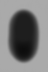

157


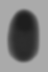

141


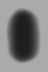

141


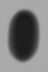

144


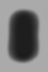

144


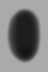

153


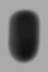

154


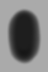

150


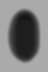

151


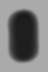

146


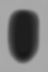

148


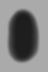

144


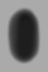

147


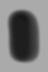

147


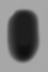

155


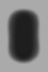

144


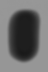

127


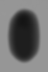

131


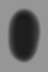

125


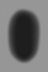

124


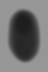

122


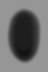

132


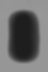

123


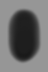

126


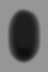

138


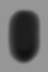

135


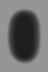

124


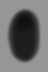

136


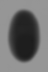

122


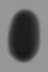

130


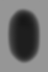

128


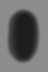

113


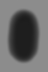

113


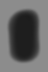

113


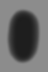

111


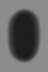

113


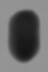

129


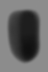

125


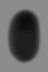

128


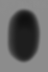

126


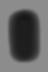

118


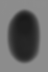

115


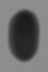

116


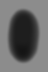

121


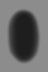

113


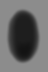

122


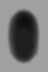

147


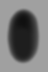

145


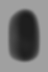

134


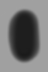

135


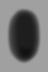

144


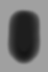

141


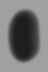

133


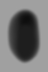

147


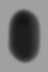

141


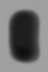

146


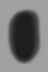

134


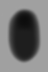

148


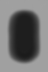

134


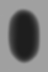

132


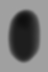

146


In [ ]:
train_to_depth_paths = sorted(glob.glob('/content/train_to_depth/*.png')) # 파일을 1000장마다 한 번씩 출력하기 -> 중간에 이상이 있다면 그냥 추가학습 하지말고 sim data를 잘 학습시켜야 함.
idx = 0
M = 0
for i in train_to_depth_paths:
  if(idx%1000==0):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    cv2_imshow(img)
    print(np.max(img) - np.min(img))
  idx+=1

## train 데이터와 train_to_depth, avg_depth 이용해서 추가학습

In [ ]:
# train-SEM 데이터
sem_paths = sorted(glob.glob('/content/train/SEM/*/*/*.png'), key=lambda x : x[-14:-4])   # 이미지 번호에 맞게 정렬

depth_paths = sorted(glob.glob("/content/train_to_depth/*.png"))

sem_paths[:5], depth_paths[:5]

(['/content/train/SEM/Depth_140/site_00201/SEM_000001.png',
  '/content/train/SEM/Depth_140/site_00413/SEM_000002.png',
  '/content/train/SEM/Depth_140/site_00097/SEM_000005.png',
  '/content/train/SEM/Depth_140/site_00099/SEM_000006.png',
  '/content/train/SEM/Depth_140/site_00475/SEM_000008.png'],
 ['/content/train_to_depth/SEM_000001.png',
  '/content/train_to_depth/SEM_000002.png',
  '/content/train_to_depth/SEM_000005.png',
  '/content/train_to_depth/SEM_000006.png',
  '/content/train_to_depth/SEM_000008.png'])

### Simulation 중 추가학습 레이블에 이용할 20%데이터 가져오기 (train 15%, val 5%)

In [ ]:
add_train_ratio = 0.95

In [ ]:
#add train sem paths 정하기

vc1_80 = sim_sem_c1_80_paths[int(len_80*ratio):int(len_80*add_train_ratio)]
vc1_81 = sim_sem_c1_81_paths[int(len_81*ratio):int(len_81*add_train_ratio)]
vc1_82 = sim_sem_c1_82_paths[int(len_82*ratio):int(len_82*add_train_ratio)]
vc1_83 = sim_sem_c1_83_paths[int(len_83*ratio):int(len_83*add_train_ratio)]
vc1_84 = sim_sem_c1_84_paths[int(len_84*ratio):int(len_84*add_train_ratio)]
vc1 = vc1_80 + vc1_81 + vc1_82 + vc1_83 + vc1_84

vc2_80 = sim_sem_c2_80_paths[int(len_80*ratio):int(len_80*add_train_ratio)]
vc2_81 = sim_sem_c2_81_paths[int(len_81*ratio):int(len_81*add_train_ratio)]
vc2_82 = sim_sem_c2_82_paths[int(len_82*ratio):int(len_82*add_train_ratio)]
vc2_83 = sim_sem_c2_83_paths[int(len_83*ratio):int(len_83*add_train_ratio)]
vc2_84 = sim_sem_c2_84_paths[int(len_84*ratio):int(len_84*add_train_ratio)]
vc2 = vc2_80 + vc2_81 + vc2_82 + vc2_83 + vc2_84

vc3_80 = sim_sem_c3_80_paths[int(len_80*ratio):int(len_80*add_train_ratio)]
vc3_81 = sim_sem_c3_81_paths[int(len_81*ratio):int(len_81*add_train_ratio)]
vc3_82 = sim_sem_c3_82_paths[int(len_82*ratio):int(len_82*add_train_ratio)]
vc3_83 = sim_sem_c3_83_paths[int(len_83*ratio):int(len_83*add_train_ratio)]
vc3_84 = sim_sem_c3_84_paths[int(len_84*ratio):int(len_84*add_train_ratio)]
vc3 = vc3_80 + vc3_81 + vc3_82 + vc3_83 + vc3_84

vc4_80 = sim_sem_c4_80_paths[int(len_80*ratio):int(len_80*add_train_ratio)]
vc4_81 = sim_sem_c4_81_paths[int(len_81*ratio):int(len_81*add_train_ratio)]
vc4_82 = sim_sem_c4_82_paths[int(len_82*ratio):int(len_82*add_train_ratio)]
vc4_83 = sim_sem_c4_83_paths[int(len_83*ratio):int(len_83*add_train_ratio)]
vc4_84 = sim_sem_c4_84_paths[int(len_84*ratio):int(len_84*add_train_ratio)]
vc4 = vc4_80 + vc4_81 + vc4_82 + vc4_83 + vc4_84

add_sim_tsvc = vc1 + vc2 + vc3 + vc4

In [ ]:
# add train depth paths 정하기

dvc1_80 = sim_depth_c1_80_paths[int(len_80*ratio):int(len_80*add_train_ratio)]
dvc1_81 = sim_depth_c1_81_paths[int(len_81*ratio):int(len_81*add_train_ratio)]
dvc1_82 = sim_depth_c1_82_paths[int(len_82*ratio):int(len_82*add_train_ratio)]
dvc1_83 = sim_depth_c1_83_paths[int(len_83*ratio):int(len_83*add_train_ratio)]
dvc1_84 = sim_depth_c1_84_paths[int(len_84*ratio):int(len_84*add_train_ratio)]
dvc1 = dvc1_80 + dvc1_81 + dvc1_82 + dvc1_83 + dvc1_84

dvc2_80 = sim_depth_c2_80_paths[int(len_80*ratio):int(len_80*add_train_ratio)]
dvc2_81 = sim_depth_c2_81_paths[int(len_81*ratio):int(len_81*add_train_ratio)]
dvc2_82 = sim_depth_c2_82_paths[int(len_82*ratio):int(len_82*add_train_ratio)]
dvc2_83 = sim_depth_c2_83_paths[int(len_83*ratio):int(len_83*add_train_ratio)]
dvc2_84 = sim_depth_c2_84_paths[int(len_84*ratio):int(len_84*add_train_ratio)]
dvc2 = dvc2_80 + dvc2_81 + dvc2_82 + dvc2_83 + dvc2_84

dvc3_80 = sim_depth_c3_80_paths[int(len_80*ratio):int(len_80*add_train_ratio)]
dvc3_81 = sim_depth_c3_81_paths[int(len_81*ratio):int(len_81*add_train_ratio)]
dvc3_82 = sim_depth_c3_82_paths[int(len_82*ratio):int(len_82*add_train_ratio)]
dvc3_83 = sim_depth_c3_83_paths[int(len_83*ratio):int(len_83*add_train_ratio)]
dvc3_84 = sim_depth_c3_84_paths[int(len_84*ratio):int(len_84*add_train_ratio)]
dvc3 = dvc3_80 + dvc3_81 + dvc3_82 + dvc3_83 + dvc3_84

dvc4_80 = sim_depth_c4_80_paths[int(len_80*ratio):int(len_80*add_train_ratio)]
dvc4_81 = sim_depth_c4_81_paths[int(len_81*ratio):int(len_81*add_train_ratio)]
dvc4_82 = sim_depth_c4_82_paths[int(len_82*ratio):int(len_82*add_train_ratio)]
dvc4_83 = sim_depth_c4_83_paths[int(len_83*ratio):int(len_83*add_train_ratio)]
dvc4_84 = sim_depth_c4_84_paths[int(len_84*ratio):int(len_84*add_train_ratio)]
dvc4 = dvc4_80 + dvc4_81 + dvc4_82 + dvc4_83 + dvc4_84

add_sim_tdvc = dvc1 + dvc2 + dvc3 + dvc4

In [ ]:
# add valid sem paths 정하기

vc1_80 = sim_sem_c1_80_paths[int(len_80*add_train_ratio):]
vc1_81 = sim_sem_c1_81_paths[int(len_81*add_train_ratio):]
vc1_82 = sim_sem_c1_82_paths[int(len_82*add_train_ratio):]
vc1_83 = sim_sem_c1_83_paths[int(len_83*add_train_ratio):]
vc1_84 = sim_sem_c1_84_paths[int(len_84*add_train_ratio):]
vc1 = vc1_80 + vc1_81 + vc1_82 + vc1_83 + vc1_84

vc2_80 = sim_sem_c2_80_paths[int(len_80*add_train_ratio):]
vc2_81 = sim_sem_c2_81_paths[int(len_81*add_train_ratio):]
vc2_82 = sim_sem_c2_82_paths[int(len_82*add_train_ratio):]
vc2_83 = sim_sem_c2_83_paths[int(len_83*add_train_ratio):]
vc2_84 = sim_sem_c2_84_paths[int(len_84*add_train_ratio):]
vc2 = vc2_80 + vc2_81 + vc2_82 + vc2_83 + vc2_84

vc3_80 = sim_sem_c3_80_paths[int(len_80*add_train_ratio):]
vc3_81 = sim_sem_c3_81_paths[int(len_81*add_train_ratio):]
vc3_82 = sim_sem_c3_82_paths[int(len_82*add_train_ratio):]
vc3_83 = sim_sem_c3_83_paths[int(len_83*add_train_ratio):]
vc3_84 = sim_sem_c3_84_paths[int(len_84*add_train_ratio):]
vc3 = vc3_80 + vc3_81 + vc3_82 + vc3_83 + vc3_84

vc4_80 = sim_sem_c4_80_paths[int(len_80*add_train_ratio):]
vc4_81 = sim_sem_c4_81_paths[int(len_81*add_train_ratio):]
vc4_82 = sim_sem_c4_82_paths[int(len_82*add_train_ratio):]
vc4_83 = sim_sem_c4_83_paths[int(len_83*add_train_ratio):]
vc4_84 = sim_sem_c4_84_paths[int(len_84*add_train_ratio):]
vc4 = vc4_80 + vc4_81 + vc4_82 + vc4_83 + vc4_84

add_sim_vsvc = vc1 + vc2 + vc3 + vc4

In [ ]:
# valid depth 길이 정하기

dvc1_80 = sim_depth_c1_80_paths[int(len_80*add_train_ratio):]
dvc1_81 = sim_depth_c1_81_paths[int(len_81*add_train_ratio):]
dvc1_82 = sim_depth_c1_82_paths[int(len_82*add_train_ratio):]
dvc1_83 = sim_depth_c1_83_paths[int(len_83*add_train_ratio):]
dvc1_84 = sim_depth_c1_84_paths[int(len_84*add_train_ratio):]
dvc1 = dvc1_80 + dvc1_81 + dvc1_82 + dvc1_83 + dvc1_84

dvc2_80 = sim_depth_c2_80_paths[int(len_80*add_train_ratio):]
dvc2_81 = sim_depth_c2_81_paths[int(len_81*add_train_ratio):]
dvc2_82 = sim_depth_c2_82_paths[int(len_82*add_train_ratio):]
dvc2_83 = sim_depth_c2_83_paths[int(len_83*add_train_ratio):]
dvc2_84 = sim_depth_c2_84_paths[int(len_84*add_train_ratio):]
dvc2 = dvc2_80 + dvc2_81 + dvc2_82 + dvc2_83 + dvc2_84

dvc3_80 = sim_depth_c3_80_paths[int(len_80*add_train_ratio):]
dvc3_81 = sim_depth_c3_81_paths[int(len_81*add_train_ratio):]
dvc3_82 = sim_depth_c3_82_paths[int(len_82*add_train_ratio):]
dvc3_83 = sim_depth_c3_83_paths[int(len_83*add_train_ratio):]
dvc3_84 = sim_depth_c3_84_paths[int(len_84*add_train_ratio):]
dvc3 = dvc3_80 + dvc3_81 + dvc3_82 + dvc3_83 + dvc3_84

dvc4_80 = sim_depth_c4_80_paths[int(len_80*add_train_ratio):]
dvc4_81 = sim_depth_c4_81_paths[int(len_81*add_train_ratio):]
dvc4_82 = sim_depth_c4_82_paths[int(len_82*add_train_ratio):]
dvc4_83 = sim_depth_c4_83_paths[int(len_83*add_train_ratio):]
dvc4_84 = sim_depth_c4_84_paths[int(len_84*add_train_ratio):]
dvc4 = dvc4_80 + dvc4_81 + dvc4_82 + dvc4_83 + dvc4_84

add_sim_vdvc = dvc1 + dvc2 + dvc3 + dvc4

In [ ]:
add_train_sem_paths = sem_paths[:int(len(sem_paths)*0.8)]
add_val_sem_paths = sem_paths[int(len(sem_paths)*0.8):]

add_train_depth_paths = depth_paths[:int(len(sem_paths)*0.8)]
add_val_depth_paths = depth_paths[int(len(sem_paths)*0.8):]

In [ ]:
df = pd.read_csv('/content/train/average_depth.csv')

In [ ]:
# bestmodel을 통해 만들어진 train_to_depth 이미지와 average_depth.csv 매칭
data = {}
table = {k: v for k, v in zip(df["0"].values, df["1"].values)}


for sem, depth in zip(sem_paths, depth_paths):
  sem = sem.split("/")
  depth_split = depth.split("/")
  if sem[-1] == depth_split[-1]:
    data[depth] = table[f"{sem[-3].lower()}_{sem[-2]}"]

DF = pd.DataFrame(list(data.items()), columns=["image", "depth"])

depth_list = []

for Data in DF['depth']:
  depth_list.append(Data)

# 리스트 내용물 타입 확인
print((depth_list[0]))

139.1776843


In [ ]:
add_train_depth_list = depth_list[:int(len(sem_paths)*0.8)]
add_val_depth_list = depth_list[int(len(sem_paths)*0.8):]

In [ ]:
at_origindataset = TransformedDataset(add_train_sem_paths, add_train_depth_paths, torch.Tensor([1,])) + TransformedDataset(add_sim_tsvc,add_sim_tdvc, torch.Tensor([0,]))

at_horizontalTransformeddataset = TransformedDataset(add_train_sem_paths, add_train_depth_paths, torch.Tensor([1,]), transform = horizontalTransform) + TransformedDataset(add_sim_tsvc,add_sim_tdvc, torch.Tensor([0,]),transform = horizontalTransform)
at_verticalTransformeddataset = TransformedDataset(add_train_sem_paths, add_train_depth_paths, torch.Tensor([1,]), transform = verticalTransform) + TransformedDataset(add_sim_tsvc,add_sim_tdvc, torch.Tensor([0,]), transform = verticalTransform)
at_mixdataset = TransformedDataset(add_train_sem_paths, add_train_depth_paths, torch.Tensor([1,]), transform = mixTransform) + TransformedDataset(add_sim_tsvc,add_sim_tdvc, torch.Tensor([0,]), transform = mixTransform)

add_train_dataset = at_origindataset + at_horizontalTransformeddataset + at_verticalTransformeddataset + at_mixdataset # add_train_dataset 생성

In [ ]:
av_origindataset = TransformedDataset(add_val_sem_paths,add_val_depth_paths, torch.Tensor([1,])) + TransformedDataset(add_sim_vsvc, add_sim_vdvc, torch.Tensor([0,]))
av_horizontalTransformeddataset = TransformedDataset(add_val_sem_paths,add_val_depth_paths, torch.Tensor([1,]), transform = horizontalTransform) + TransformedDataset(add_sim_vsvc, add_sim_vdvc, torch.Tensor([0,]),transform = horizontalTransform)
av_verticalTransformeddataset = TransformedDataset(add_val_sem_paths,add_val_depth_paths, torch.Tensor([1,]), transform = verticalTransform) + TransformedDataset(add_sim_vsvc, add_sim_vdvc, torch.Tensor([0,]), transform = verticalTransform)
av_mixdataset = TransformedDataset(add_val_sem_paths,add_val_depth_paths, torch.Tensor([1,]), transform = mixTransform) + TransformedDataset(add_sim_vsvc, add_sim_vdvc, torch.Tensor([0,]), transform = mixTransform)

add_valid_dataset = av_origindataset + av_horizontalTransformeddataset + av_verticalTransformeddataset + av_mixdataset # add_valid_dataset 생성

In [ ]:
add_train_loader = DataLoader(add_train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

add_val_loader = DataLoader(add_valid_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [ ]:
len(add_train_dataset), len(add_valid_dataset)

(298076, 83236)

### Train 실제 SEM 환경에서의 train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, alpha, device):       # 해당 모델은 1)img를 생성하는 임무, 2)depth를 실수로 예측하는 임무 
    model.to(device)                                              
    criterion_img = nn.L1Loss().to(device)   
    criterion_depth = nn.CrossEntropyLoss().to(device)                                    # loss를 2가지로 설정 1) img 에 대한 loss              
    best_score = 999999
    best_model = None
    best_hist = []
    for epoch in range(1, CFG['EPOCHS']+1):                                     # 학습이 진행되는 동안
        model.train()
        train_loss = []                                                         # img + depth 에 대한 loss 리스트 생성
       
        for sem, depth, label in tqdm(iter(train_loader)):                   # simulation을 이용한 train_loader 에는 sem 이미지, depth 이미지, depth 이미지로 추정한 depth 값이 있음
            sem = sem.float().to(device)                                        # 각각의 값을 device로 전달하면서 실수화
            depth = depth.float().to(device)
            label = label.float().to(device)

            optimizer.zero_grad()                                               # 기울기 초기화
            
            model_pred_img,model_pred_label = model(sem)                        # model의 예측값이 2개이고 순서대로 img, depth 값임 
            
            loss_img = criterion_img(model_pred_img, depth)                     # img에 대한 loss 계산
            
            loss_label = criterion_depth(model_pred_label, label)            # depth에 대한 loss 계산

            total_loss = loss_img - alpha*loss_label

            total_loss.backward()

            optimizer.step()                                                    
            
            train_loss.append(total_loss.item())                            
            
        
        val_img_loss, val_img_rmse,val_label_loss, val_label_rmse,val_total_loss, val_total_rmse = validation(model, criterion_img, criterion_depth,val_loader, alpha, device) # 검증 진행
        print(f'Epoch : [{epoch}] Train Total Loss : [{np.mean(train_loss):.5f}] Val img Loss : [{val_img_loss:.5f}] Val img RMSE : [{val_img_rmse:.5f}] Val Total RMSE : [{val_total_rmse:.5f}]')
        if best_score > val_total_rmse:                                           # rmse가 더 낮다고 판단되면 좋은 모델이라고 생각하고 교체
            best_score = val_total_rmse
            best_model = model
            best_hist = [epoch, np.mean(train_loss), val_img_rmse, val_total_rmse]
        
        if scheduler is not None:                                               
            scheduler.step()

    print("<<BEST>>")                                                           # 제일 좋은 모델의 값들 출력
    print(f"Epoch : {best_hist[0]} / Train Loss : {best_hist[1]:.5f} / Val Loss : {best_hist[2]:.5f} / Val RMSE : {best_score} / Val Total RMSE : {best_hist[3]:.5f}")      
    
    
    return best_model

In [ ]:
def validation(model, criterion_img, criterion_depth, val_loader, alpha, device):      # 검증 : 마찬가지로 기존의 baseline 코드에서 기준이 2가지로 바뀌었기 떄문에
    model.eval()                                                                # img에 대한 loss, depth에 대한 loss로 뒀음
    b_rmse_img = nn.MSELoss().to(device)                                        # img에 대한 rmse 설정
    
    val_img_loss = []                                                           # 값을 담아놓을 리스트들 선언
    val_img_rmse = []

    val_label_loss = []
    val_label_rmse = []

    total_loss_list = []
    total_rmse_list = []

    with torch.no_grad():                                                       # 기울기 변화가 없을 때까지
        for sem, depth,label in tqdm(iter(val_loader)):                      # val_loader 또한 sem이미지, depth이미지, depth이미지로 추정한 depth 값이 있음
            sem = sem.float().to(device)                                        # 각각의 값을 device로 전달하면서 실수화
            depth = depth.float().to(device)
            label = label.float().to(device)        

            model_pred_img, model_pred_label = model(sem)                       # model의 예측값이 2개이고 순서대로 img 값임
            loss_img = criterion_img(model_pred_img, depth)                     # img에 대한 loss 계산
            loss_label = criterion_depth(model_pred_label, label)
            # image 
            pred = (model_pred_img*255.).type(torch.int8).float()               # 예측 depth 이미지
            true = (depth*255.).type(torch.int8).float()                        # 실제 depth 이미지

            b_rmse_img = torch.sqrt(criterion_img(pred, true))                  # 두 값의 rmse

            b_rmse_label = torch.sqrt(loss_label)
            
            val_img_loss.append(loss_img.item())                                # 각각의 loss, rmse 리스트에 추가하기
            val_img_rmse.append(b_rmse_img.item())

            val_label_loss.append(loss_label.item())
            val_label_rmse.append(b_rmse_label.item())

            # Total
            total_loss = loss_img - alpha*loss_label
            b_rmse_total = torch.sqrt(total_loss*total_loss)
            total_loss_list.append(total_loss.item())
            total_rmse_list.append(b_rmse_total.item())

    return np.mean(val_img_loss), np.mean(val_img_rmse), np.mean(val_label_loss), np.mean(val_label_rmse), np.mean(total_loss_list), np.mean(total_rmse_list)

In [ ]:
Model = infer_model
Model.eval()
optimizer = torch.optim.Adam(params = Model.parameters(), lr = 1e-3)            # 추가학습시에 초기 lr을 크게 해버리면 원래 학습했던 포인트를 잃어버리는 것으로 추측됨. 따라서 lr을 조금 작게 설정해주었음.
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)

infer_model = train(Model, optimizer, add_train_loader, add_val_loader, scheduler, CFG['ALPHA'], device)

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [1] Train Total Loss : [0.00485] Val img Loss : [0.00435] Val img RMSE : [1.47080] Val Total RMSE : [0.00435]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [2] Train Total Loss : [0.00442] Val img Loss : [0.00397] Val img RMSE : [1.54852] Val Total RMSE : [0.00397]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [3] Train Total Loss : [0.00426] Val img Loss : [0.00375] Val img RMSE : [1.49912] Val Total RMSE : [0.00375]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [4] Train Total Loss : [0.00402] Val img Loss : [0.00398] Val img RMSE : [1.52703] Val Total RMSE : [0.00398]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [5] Train Total Loss : [0.00386] Val img Loss : [0.00395] Val img RMSE : [1.40219] Val Total RMSE : [0.00395]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [6] Train Total Loss : [0.00366] Val img Loss : [0.00386] Val img RMSE : [1.39940] Val Total RMSE : [0.00386]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [7] Train Total Loss : [0.00373] Val img Loss : [0.00394] Val img RMSE : [1.34215] Val Total RMSE : [0.00394]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [8] Train Total Loss : [0.00348] Val img Loss : [0.00413] Val img RMSE : [1.58741] Val Total RMSE : [0.00413]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [9] Train Total Loss : [0.00340] Val img Loss : [0.00378] Val img RMSE : [1.48490] Val Total RMSE : [0.00378]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [10] Train Total Loss : [0.00334] Val img Loss : [0.00408] Val img RMSE : [1.50776] Val Total RMSE : [0.00408]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [11] Train Total Loss : [0.00331] Val img Loss : [0.00339] Val img RMSE : [1.38354] Val Total RMSE : [0.00339]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [12] Train Total Loss : [0.00319] Val img Loss : [0.00395] Val img RMSE : [1.27072] Val Total RMSE : [0.00395]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [13] Train Total Loss : [0.00310] Val img Loss : [0.00334] Val img RMSE : [1.39917] Val Total RMSE : [0.00334]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [14] Train Total Loss : [0.00304] Val img Loss : [0.00325] Val img RMSE : [1.38851] Val Total RMSE : [0.00325]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [15] Train Total Loss : [0.00304] Val img Loss : [0.00321] Val img RMSE : [1.35693] Val Total RMSE : [0.00321]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [16] Train Total Loss : [0.00293] Val img Loss : [0.00341] Val img RMSE : [1.45096] Val Total RMSE : [0.00341]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [17] Train Total Loss : [0.00292] Val img Loss : [0.00315] Val img RMSE : [1.41967] Val Total RMSE : [0.00315]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [18] Train Total Loss : [0.00286] Val img Loss : [0.00313] Val img RMSE : [1.39043] Val Total RMSE : [0.00313]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [19] Train Total Loss : [0.00282] Val img Loss : [0.00321] Val img RMSE : [1.40481] Val Total RMSE : [0.00321]


  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

Epoch : [20] Train Total Loss : [0.00278] Val img Loss : [0.00318] Val img RMSE : [1.40606] Val Total RMSE : [0.00318]
<<BEST>>
Epoch : 18 / Train Loss : 0.00286 / Val Loss : 1.39043 / Val RMSE : 0.0031345756089646718 / Val Total RMSE : 0.00313


## Inference & Submission

In [ ]:
test_sem_path_list = sorted(glob.glob('/content/test/SEM/*.png'))

In [ ]:
test_dataset = TransformedDataset(test_sem_path_list, None, torch.Tensor([1,]))
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [ ]:
import zipfile
def inference2(model, test_loader, device):
    model.to(device)
    model.eval()
    
    result_name_list = []
    result_list = []
    with torch.no_grad():
        for sem, name,label in tqdm(iter(test_loader)):
            sem = sem.float().to(device)
            model_pred_img,model_pred_label = model(sem)
            
            for pred, img_name in zip(model_pred_img, name):
                pred = pred.cpu().numpy().transpose(1,2,0)*255.           
                save_img_path = f'{img_name}'
                #cv2.imwrite(save_img_path, pred)
                result_name_list.append(save_img_path)
                result_list.append(pred)
    
    os.makedirs('/content/submission0905_a', exist_ok=True)
    os.chdir("/content/submission0905_a/")
    sub_imgs = []
    for path, pred_img in zip(result_name_list, result_list):
        cv2.imwrite(path, pred_img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("/content/submission_0905_onlysimul.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()

In [ ]:
import zipfile
def inference1(model, test_loader, device):
    model.to(device)
    model.eval()
    
    result_name_list = []
    result_list = []
    with torch.no_grad():
        for sem, name,label in tqdm(iter(test_loader)):
            sem = sem.float().to(device)
            model_pred_img,model_pred_label = model(sem)
            
            for pred, img_name in zip(model_pred_img, name):
                pred = pred.cpu().numpy().transpose(1,2,0)*255.           
                save_img_path = f'{img_name}'
                #cv2.imwrite(save_img_path, pred)
                result_name_list.append(save_img_path)
                result_list.append(pred)
    
    os.makedirs('/content/submission0905_full', exist_ok=True)
    os.chdir("/content/submission0905_full/")
    sub_imgs = []
    for path, pred_img in zip(result_name_list, result_list):
        cv2.imwrite(path, pred_img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("/content/submission_0905_full.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()

In [ ]:
cd /content/

/content


In [ ]:
Model = torch.load('/content/drive/MyDrive/basemodel_0904.pt') # 모델 불러오기

In [ ]:
inference1(infer_model, test_loader, device) # 추가학습 해서 진행

  0%|          | 0/204 [00:00<?, ?it/s]

In [ ]:
inference2(Model, test_loader, device) # 추가학습 없이 진행

  0%|          | 0/407 [00:00<?, ?it/s]

140


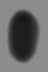

140


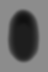

140


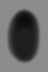

150


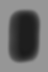

160


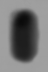

160


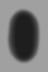

160


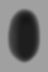

161


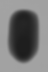

160


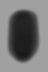

170


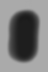

140


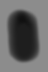

140


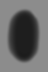

140


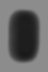

140


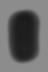

150


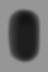

150


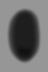

150


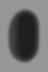

150


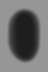

160


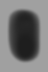

160


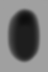

160


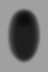

160


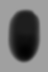

170


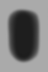

170


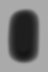

170


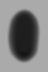

170


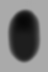

In [ ]:
test_depth_paths = sorted(glob.glob('/content/submission0905_full/*.png'))           # test 이미지 1000장마다 출력해서 이상하지 않은지 확인
idx = 0
for i in test_depth_paths:
  if(idx%1000==0):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    print(np.max(img[36]))
    cv2_imshow(img)
    #print(img)
  idx+=1